In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../d03_src/')
import process_graph
import model_MCMC
import model_pooling

# How to use the model

In this notebook, we give examples of how to run our main chain through the function `model_MCMC.run_MCMC`, which samples from the model described in our paper.

## 1. Function Signature

The full chain has the following signature

In [2]:
model_MCMC.run_MCMC?

Signature:
model_MCMC.run_MCMC(
    graph,
    covariates=None,
    fixed_T=False,
    fixed_params=False,
    T=None,
    params=None,
    MCMC_iterations=5000,
    MCMC_burnin=500,
    MCMC_return_burnin=True,
    MCMC_thinfrac=1.0,
    MCMC_verbose=False,
    params_sample_start=None,
    params_sample_dict=None,
    debug=False,
    return_stepsize=False,
)
Docstring:
Runs a Markov Chain MonteCarlo to sample either the variables (A and T) or the
  parameters (alphas and thetas) of our model. Must give either true parameters or T in
  order to sample/infer the variable A and the other.
  
Model parameter dictionaries keys are `alpha0`, ... `alphaM`, `theta0`, and `theta1`.

Parameters
----------
graph : Networkx.Graph
    graph object whose nodes correspond to spatial
    locations, must be labeled 0...N-1

covariates : np.Array of shape N x M or None
    demographic covariates per node that will be used
    in the regression to determine reporting rate. If None,
    report rate is 

## 2. Sampling $\vec{\alpha}$, $\theta_0$, and $\theta_1$:

Our main contribution is the implementation of the heterogeneous reporting model to describe urban crowdsourcing settings. As such, we would like to sample the model parameters from observed report data. This is the mode where we have `fixed_T=True` in the above function. 

### 2a. What data do we need:

1. A graph of $N$ nodes, in the form of a `networkX.Graph` object. Nodes must be labeled as integers from $0$ to $N-1$.

In [3]:
graph = process_graph.generate_graph_grid(10) #this will generate a 10x10 grid graph
N = graph.order()
assert list(graph.nodes()) == list(range(N))  #verify the labeling is 0,... N-1

2. An array of length $N$ corresponding to the observed report data. Array must be indexed as nodes in the graph.

In [4]:
T = np.random.binomial(n=1, p=0.5, size=N) #trivial example

3. An array of shape $N\times M$ containing covariates the $M$ covariates for each node. We recommend that these covariates are standardized---no pre-processing is done inside the function.

In [5]:
M = 6                              #Setting with 6 covariates
covariates = np.random.rand(N, M) 

In case we want a fixed report rate $\psi_i = \alpha$ for all nodes, we can pass `covariates=None`. This is what we do to run the homogeneous reporting model, described in the paper.

### 2b. Initializing the chain:

To describe the chain, we need to specify the number of iterations, the number of discarded burn-in iterations, and the thinning fraction:

In [6]:
MCMC_iterations = 30   #we usually do 15,000
MCMC_burnin = 20       #we usually do 10,000
MCMC_thinfrac = 0.75 

By default, we still return the the burn-in iterations (useful in checking convergence). If you would like to fully discard them, set `MCMC_return_burnin=False`

### 2c. Prior distributions:

To speficy the prior distributions, we use the dictionary of user hyperparameters. Note that we may pass priors on $\psi$ through a Beta distribution in case we do not have covariates, or through a list of length $M+1$ (intercept is always included) in case of regressing on covariates and then $\alpha_k$ is normally distributed as described in the paper, on the appendix.

In [7]:
priors = {'psi_Beta_priormean': 0.5,                 #this is only used if covariates = None
          'psi_Beta_priorstrength': 2,               #this is only used if covariates = None

          'psi_Reg_priormean': [0.]*(M+1),           #this is only used if covariates != None
          'psi_Reg_priorsd': [1.]+[0.5]*M,           #this is only used if covariates != None
      
          'theta_SVE_priormean':[0., 0.1],
          'theta_SVE_priorsigma':[0.1, 0.05]}

The hyperparameter dictionary also allows for users to define hyperparameters of the regression or SVE algorithm:

In [8]:
Reg_HP = {'psi_method': 'Beta' if covariates is None else 'Reg',
          'psi_Reg_warmup': 50}

SVE_HP = {'theta_method':'SVE',
          
          'theta_SVE_warmup': 1,
          'theta_SVE_auxiliary': 50,
          'theta_SVE_proposalsigma': 0.05,
      
          'theta_SVE_adaptive': True,                  #Whether to adapt stepsize during burn-in
          'theta_SVE_adaptiveiter': 5,                 #Every 5 iterations of the chain we adapt the stepsize
          'theta_SVE_adaptivebounds':(0.25, 0.6)}      #Keep stepsize between these bounds during burn-in

HP = priors|Reg_HP|SVE_HP

### 2d. Sample run

Here we run with `verbose=True` to have a progress bar. Note that the NUTS sampler for the regression will output at every iteration

In [9]:
sampled_A, _, sampled_params = model_MCMC.run_MCMC(graph,
                                                   covariates=covariates,
                                                   fixed_T=True,
                                                   T=T,
                                                   MCMC_iterations=MCMC_iterations,
                                                   MCMC_burnin=MCMC_burnin,
                                                   MCMC_thinfrac=MCMC_thinfrac,
                                                   MCMC_verbose=True,
                                                   params_sample_dict=HP)

Initializing the chain with fixed T
Will sample A and parameters
6 covariates passed
Initialized parameters: alpha0 = 0.65, alpha1 = 0.88, alpha2 = 0.03, alpha3 = 0.24, alpha4 = 0.35, alpha5 = 0.43, alpha6 = 0.01, theta0 = -1.12, theta1 = 1.10




  0%|                                                                                                    | 0/30 [00:00<?, ?it/s]Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha]
Sampling 1 chain for 50 tune and 1 draw iterations (50 + 1 draws total) took 0 seconds.
  3%|███                                                                                         | 1/30 [00:01<00:50,  1.74s/it]Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha]
Sampling 1 chain for 50 tune and 1 draw iterations (50 + 1 draws total) took 0 seconds.
  7%|██████▏                                                                                     | 2/30 [00:03<00:41,  1.50s/it]Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alp

The returned lists always have the same length, and we can retrieve the posterior samples by discarding the burn in:

In [10]:
assert len(sampled_A) == len(sampled_params)
posterior_A = sampled_A[MCMC_burnin:]
posterior_params = sampled_params[MCMC_burnin:]

Each entry in the $\vec{A}$ list is an inferred vector of ground-truth (so entries are either $-1$ or $1$):

In [11]:
posterior_A[0]

array([ 1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1,  1,
        1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

Each entry in the parameter list is a dictionary. To make things easier, we always return $\psi_i$---computed from alphas and covariates:

In [12]:
posterior_params[0]

{'alpha0': 1.203535707917348,
 'alpha1': 0.03795807641736151,
 'alpha2': -0.05462031439430615,
 'alpha3': -0.13591617768044106,
 'alpha4': 0.004861306614365804,
 'alpha5': 0.19606301911248528,
 'alpha6': -0.325044959234647,
 'theta0': -0.9900176617609904,
 'theta1': 0.9643556459912156,
 'psi': array([0.76338853, 0.73223943, 0.77330564, 0.72425839, 0.74067311,
        0.76028065, 0.71993146, 0.77419912, 0.75241476, 0.72594318,
        0.73671751, 0.76934126, 0.72446159, 0.72793326, 0.72521049,
        0.78972033, 0.73734888, 0.70700777, 0.74898329, 0.74885213,
        0.73376483, 0.73969862, 0.76050927, 0.75887152, 0.73979063,
        0.74991167, 0.71457171, 0.70361559, 0.71118239, 0.69430789,
        0.73497846, 0.75800407, 0.70641978, 0.70007049, 0.7336136 ,
        0.7677254 , 0.71859851, 0.74608758, 0.74974019, 0.74423707,
        0.75794897, 0.78555923, 0.77574321, 0.75641976, 0.71076847,
        0.70331269, 0.78028109, 0.74088354, 0.73267677, 0.77988036,
        0.76429549, 0.7492

## 2. Sampling $\vec{A}$ and $\vec{T}$

We can also run this chain to sample $\vec{A}$ and $\vec{T}$ with fixed parameters. This is useful to generate samples from a known distribution, as we do in the semi-synthetic data experiments. We run the model with the `fixed_params=True` mode. Note that we do not need much of the hyperparameters now, but we do need to specify the model parameters in a dictionary:

In [13]:
true_params = {'theta0':0.2,
               'theta1':0.15,
               'alpha0':0.1,
               'alpha1':-0.2,
               'alpha2':0.3,
               'alpha3':-0.01,
               'alpha4':-0.25,
               'alpha5':0.,
               'alpha6':0.05}

This is much faster---and often we only want one iteration here so we can set `MCMC_burnin` to `MCMC_iterations-1`:

In [14]:
sampled_A, sampled_T, _ = model_MCMC.run_MCMC(graph,
                                              covariates=covariates,
                                              params=true_params,
                                              fixed_params=True,
                                              MCMC_iterations=1_000,
                                              MCMC_burnin=999,
                                              MCMC_thinfrac=MCMC_thinfrac,
                                              MCMC_verbose=True)

Initializing the chain with fixed parameters
Will sample A and T
6 covariates passed
True parameters: theta0 = 0.20, theta1 = 0.15, alpha0 = 0.10, alpha1 = -0.20, alpha2 = 0.30, alpha3 = -0.01, alpha4 = -0.25, alpha5 = 0.00, alpha6 = 0.05




  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1066.87it/s]


## 3. Pooling Posteriors

We also include machinery to combine the posteriors for multiple events if they share parameters. We specifically design these functions to combine posteriors for $\alpha_1$ through $\alpha_M$, when multiple vectors $\vec{T}$ are observed. These functions can be found on the `model_pooling` module.

First, let's generate one more observed T from the same $\alpha_1, \dots \alpha_6$ parameters above:

In [15]:
true_params_2 = {k:v for k,v in true_params.items()}
true_params_2['theta0'] = -true_params['theta0']
true_params_2['theta1'] = 0.5*true_params['theta1']
true_params_2['alpha0'] = 0.

sampled_A_2, sampled_T_2, _ = model_MCMC.run_MCMC(graph,
                                                  covariates=covariates,
                                                  params=true_params_2,
                                                  fixed_params=True,
                                                  MCMC_iterations=1_000,
                                                  MCMC_burnin=999,
                                                  MCMC_thinfrac=MCMC_thinfrac,
                                                  MCMC_verbose=True)

Initializing the chain with fixed parameters
Will sample A and T
6 covariates passed
True parameters: theta0 = -0.20, theta1 = 0.07, alpha0 = 0.00, alpha1 = -0.20, alpha2 = 0.30, alpha3 = -0.01, alpha4 = -0.25, alpha5 = 0.00, alpha6 = 0.05




100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 978.33it/s]


Now we collect posteriors for parameters given each of these $\vec{T}$

In [16]:
_, _, sampled_params_1 = model_MCMC.run_MCMC(graph,
                                             covariates=covariates,
                                             fixed_T=True,
                                             T=sampled_T[-1],
                                             MCMC_iterations=250,
                                             MCMC_burnin=100,
                                             MCMC_thinfrac=MCMC_thinfrac,
                                             MCMC_return_burnin=False,
                                             params_sample_dict=HP)

_, _, sampled_params_2 = model_MCMC.run_MCMC(graph,
                                             covariates=covariates,
                                             fixed_T=True,
                                             T=sampled_T_2[-1],
                                             MCMC_iterations=250,
                                             MCMC_burnin=100,
                                             MCMC_thinfrac=MCMC_thinfrac,
                                             MCMC_return_burnin=False,
                                             params_sample_dict=HP)

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha]
Sampling 1 chain for 50 tune and 1 draw iterations (50 + 1 draws total) took 0 seconds.
Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha]
Sampling 1 chain for 50 tune and 1 draw iterations (50 + 1 draws total) took 0 seconds.
Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha]
Sampling 1 chain for 50 tune and 1 draw iterations (50 + 1 draws total) took 0 seconds.
Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha]
Sampling 1 chain for 50 tune and 1 draw iterations (50 + 1 draws total) took 0 seconds.
Only 1 samples in chain.
Auto-assigning NUTS sampler...


We can then plot the combined posterior and, using the function `model_pooling.get_combined_posterior_from_samples`, retrieve the combined 95% CIs and means of the parameter distributions

Coefficient number 1


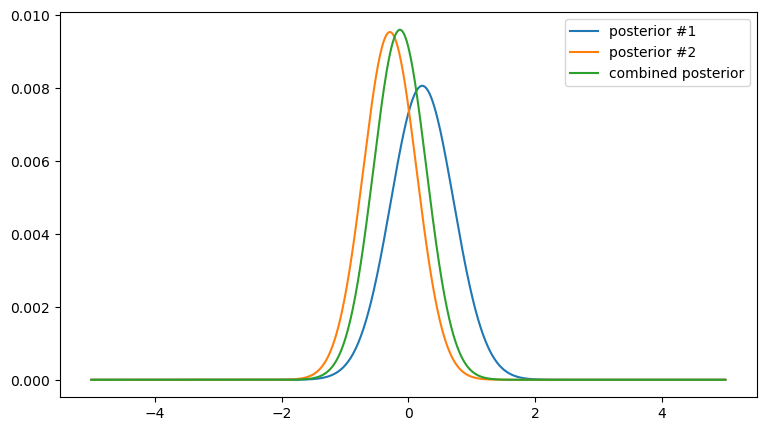

Posterior #1:   mean = 0.22, CI = (-0.73, 1.12)
Posterior #2:   mean = -0.29, CI = (-1.15, 0.52)
Posterior COMB: mean = -0.13, CI = (-0.95, 0.68)


Coefficient number 2


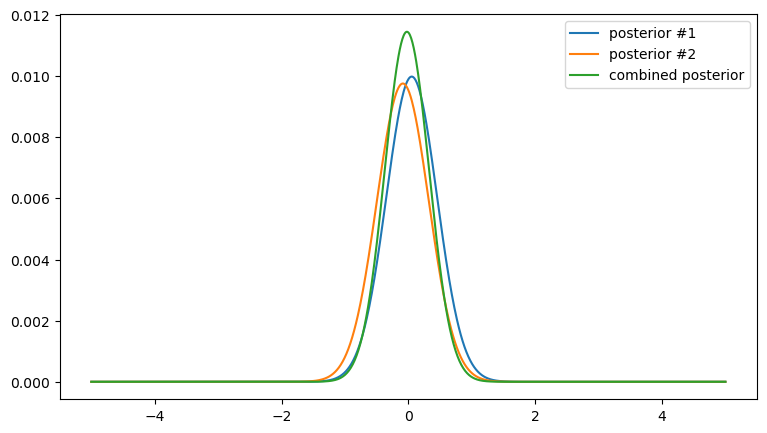

Posterior #1:   mean = 0.05, CI = (-0.76, 0.69)
Posterior #2:   mean = -0.09, CI = (-0.80, 0.87)
Posterior COMB: mean = -0.02, CI = (-0.71, 0.66)


Coefficient number 3


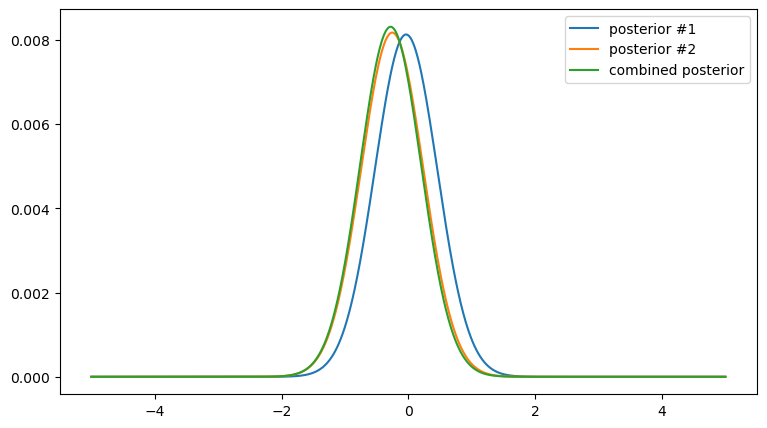

Posterior #1:   mean = -0.04, CI = (-1.16, 0.76)
Posterior #2:   mean = -0.25, CI = (-1.21, 0.58)
Posterior COMB: mean = -0.28, CI = (-1.22, 0.66)


Coefficient number 4


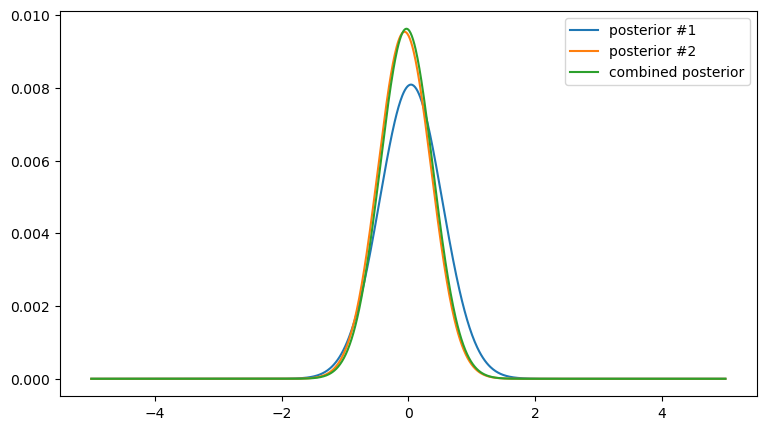

Posterior #1:   mean = 0.04, CI = (-0.87, 0.99)
Posterior #2:   mean = -0.06, CI = (-0.81, 0.86)
Posterior COMB: mean = -0.03, CI = (-0.84, 0.78)


Coefficient number 5


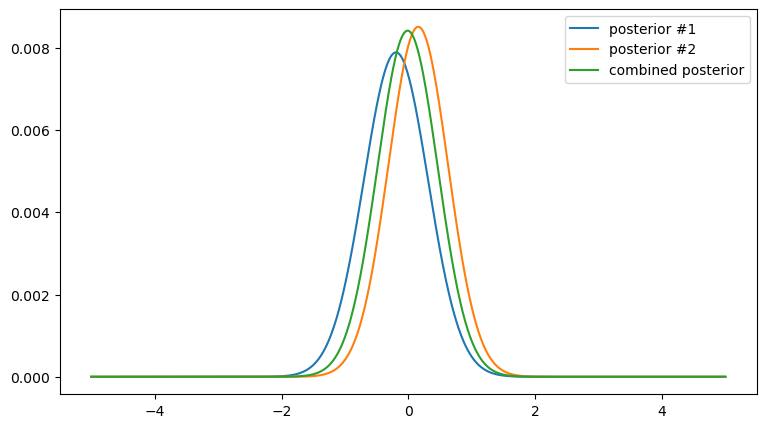

Posterior #1:   mean = -0.20, CI = (-1.07, 0.84)
Posterior #2:   mean = 0.16, CI = (-0.73, 1.10)
Posterior COMB: mean = -0.01, CI = (-0.94, 0.92)


Coefficient number 6


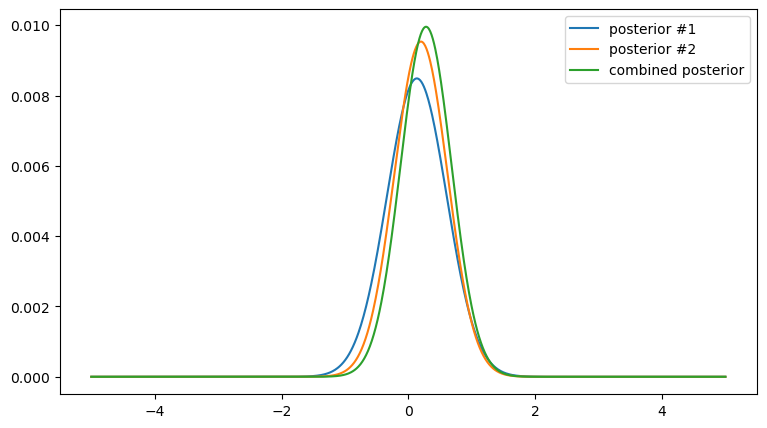

Posterior #1:   mean = 0.13, CI = (-0.72, 1.15)
Posterior #2:   mean = 0.20, CI = (-0.58, 0.96)
Posterior COMB: mean = 0.28, CI = (-0.51, 1.06)




In [17]:
#Convert the sampled dictionaries to dataframes:
sampled_params_1_df = pd.DataFrame(sampled_params_1)
sampled_params_2_df = pd.DataFrame(sampled_params_2)

#Do this for each of the parameters:
for param in range(1, M+1):

    print(f'Coefficient number {param}')
    
    #Get the samples in each data setting:
    values_1 = sampled_params_1_df[f'alpha{param}'].values
    values_2 = sampled_params_2_df[f'alpha{param}'].values

    #Combine the posteriors (and plot):
    estimate, CI = model_pooling.get_combined_posterior_from_samples([values_1, values_2],
                                                                     prior_mean=priors['psi_Reg_priormean'][param],
                                                                     prior_std=priors['psi_Reg_priorsd'][param],
                                                                     estimate_type='mean', CI_alpha=0.95, return_pdf=False,
                                                                     plot=True)
    #Print so that we can compare:
    print(f'Posterior #1:   mean = {np.mean(values_1):.2f}, CI = ({np.percentile(values_1, 2.5):.2f}, {np.percentile(values_1, 97.5):.2f})')
    print(f'Posterior #2:   mean = {np.mean(values_2):.2f}, CI = ({np.percentile(values_2, 2.5):.2f}, {np.percentile(values_2, 97.5):.2f})')
    print(f'Posterior COMB: mean = {estimate:.2f}, CI = ({CI[0]:.2f}, {CI[1]:.2f})')
    print('\n')
